In [2]:
import os
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import sys
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import  OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from numba import njit
import tifffile

import ctypes

def call_malloc_trim():
    libc = ctypes.CDLL("libc.so.6")
    # The argument 0 means to trim as much memory as possible
    libc.malloc_trim(0)

In [3]:
import dask
import dask.array as da

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)

In [4]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

In [5]:
zero_wavelength_PSF = np.array([[0,0,0],[0,1,0],[0,0,0]])
pad_amount = 100

radius = 175
wavelength = 0.65
NA = 1.45
n = 1.518
resize_amount = 1
pix_mic_conv = 0.065 / 15
apo_sigma = 10


In [6]:
PSF_darkred = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_darkred.tif")[70:-70,80:-80,80:-80]
PSF_green = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")[70:-70,80:-80,80:-80]
PSF_orange = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_orange.tif")[70:-70,80:-80,80:-80]

In [7]:
def prepare_ePSF(ePSF, pix_size_original_z, pix_size_original_xy, pix_size_new):
    ePSF = rescale(ePSF, (pix_size_original_z/pix_size_new, pix_size_original_xy / pix_size_new, pix_size_original_xy / pix_size_new), anti_aliasing=True)
    ePSF = ePSF - ePSF.min(axis=(1, 2))[:, np.newaxis, np.newaxis]
    return ePSF

real_PSFs = {
    "ePSF_darkred" : prepare_ePSF(PSF_darkred, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv),
    "ePSF_green" : prepare_ePSF(PSF_green, pix_size_original_z=0.05, pix_size_original_xy=(0.065/1.5), pix_size_new=pix_mic_conv)
}

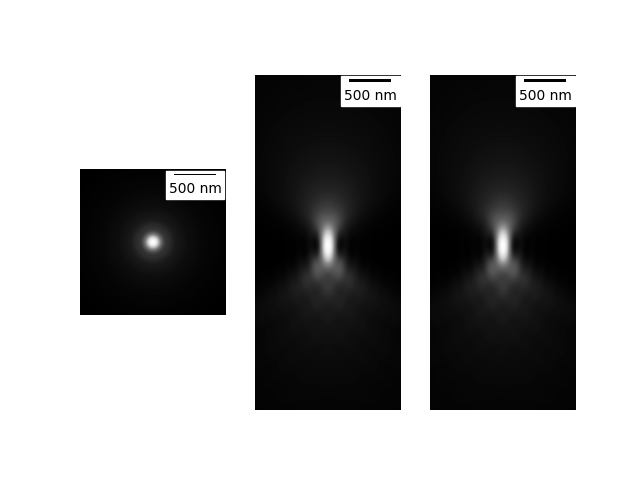

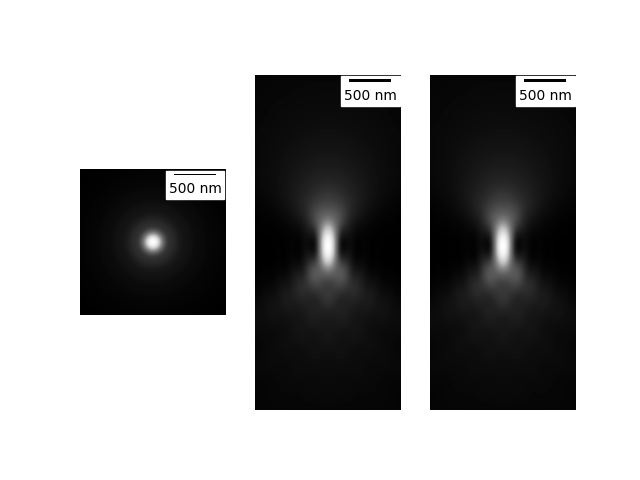

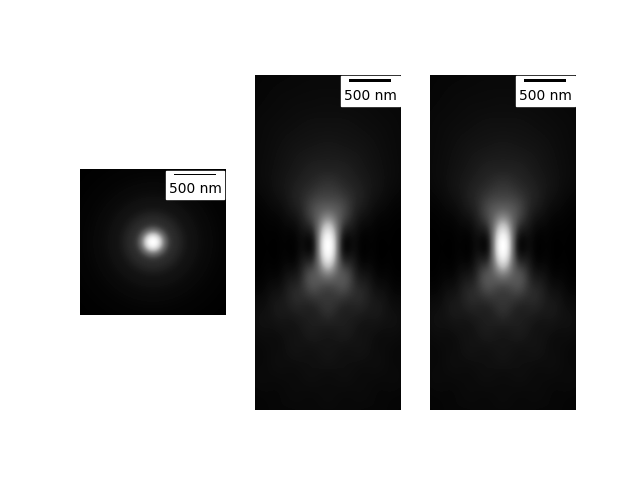

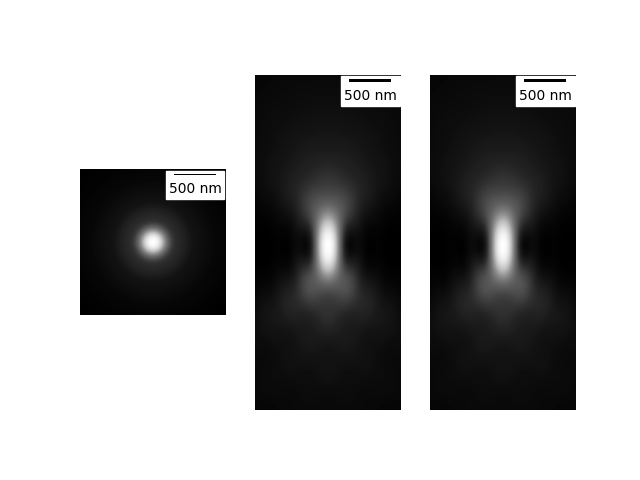

In [8]:
tPSFs = {}
for wavelength in [0.4, 0.5, 0.6, 0.7]:
    my_kernel = PSF_generator(
        radius = 200, 
        wavelength = wavelength, 
        NA=1.49, 
        n = 1.518, 
        resize_amount=1, 
        pix_mic_conv=pix_mic_conv, 
        apo_sigma = 10, 
        mode="3d fluo", 
        condenser="Ph3", 
        z_height = int(4/pix_mic_conv),
        pz = 0.5,
        working_distance = 170
    )
    my_kernel.calculate_PSF()   
    my_kernel.plot_PSF()
    tPSFs[wavelength] = my_kernel.kernel

[564]


/tmp/ipykernel_935840/2891138087.py:4: RuntimeWarning: invalid value encountered in divide
  profile = profile/profile.max()


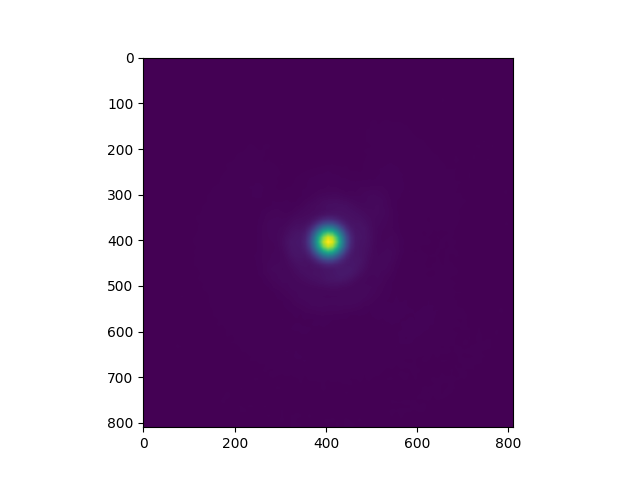

In [9]:
profile_integral = []
for layer in real_PSFs["ePSF_green"]:
    profile = layer[:,real_PSFs["ePSF_green"].shape[1]//2]
    profile = profile/profile.max()
    profile_integral.append(-np.cumsum(profile)[-1])
profile_integral = np.array(profile_integral)

plt.plot(profile_integral)
peaks = find_peaks(profile_integral, height = -100, prominence=10)[0]
plt.scatter(peaks, profile_integral[peaks])
print(peaks)
PSF_green_centre_z =  peaks[0] #- 10 * 2
plt.imshow(real_PSFs["ePSF_green"][PSF_green_centre_z])

/tmp/ipykernel_935840/2905982503.py:4: RuntimeWarning: invalid value encountered in divide
  profile = profile/profile.max()


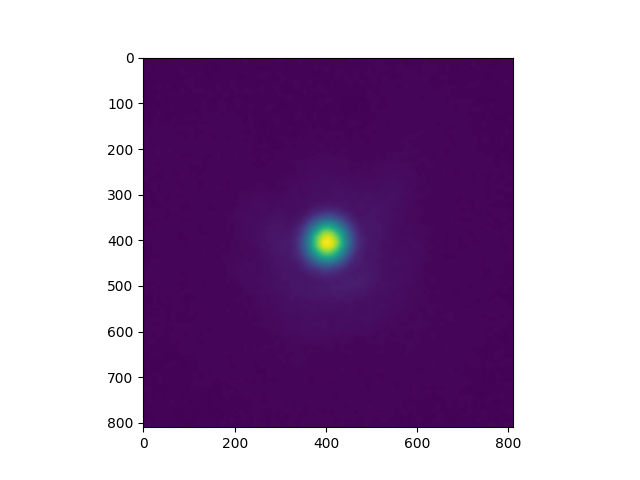

In [10]:
profile_integral = []
for layer in real_PSFs["ePSF_darkred"]:
    profile = layer[:,real_PSFs["ePSF_darkred"].shape[1]//2]
    profile = profile/profile.max()
    profile_integral.append(-np.cumsum(profile)[-1])
profile_integral = np.array(profile_integral)

plt.plot(profile_integral)
peaks = find_peaks(profile_integral, height = -110, prominence=10)[0]
plt.scatter(peaks, profile_integral[peaks])
PSF_darkred_centre_z = peaks[0] - 17*3 # Check how the peaks line up with the tails
plt.imshow(real_PSFs["ePSF_darkred"][PSF_darkred_centre_z])

In [11]:
import pickle
import gc

In [12]:
cell_length = 3.02
grid_size = 30
max_width = 3.1
cell_widths = np.arange(0.5, max_width, 0.1)+0.02
cell_types = ["membrane", "FL"]
PSF_names = list(real_PSFs.keys())
PSF_centres = [PSF_darkred_centre_z, PSF_green_centre_z]

In [13]:
cell_widths

array([0.52, 0.62, 0.72, 0.82, 0.92, 1.02, 1.12, 1.22, 1.32, 1.42, 1.52,
       1.62, 1.72, 1.82, 1.92, 2.02, 2.12, 2.22, 2.32, 2.42, 2.52, 2.62,
       2.72, 2.82, 2.92, 3.02])

In [14]:
from itertools import product

In [15]:
tPSF_names = list(tPSFs.keys())


In [16]:
a_cell = np.pad(raster_membrane_cell_3d(3/pix_mic_conv, 1/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
a_cell.shape

(228, 792, 330)

In [21]:
for cell_width in tqdm(cell_widths):
    a_cell = np.pad(raster_membrane_cell_3d(3/pix_mic_conv, cell_width/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
    cell_centre = a_cell.shape[0]//2
    for PSF_name, PSF_centre in zip(tqdm(PSF_names), PSF_centres):
        file_name = f"targeted_simulation_output/{cell_width}_iPSF_{PSF_name}.tiff"
        if not glob(file_name):
            PSF = real_PSFs[PSF_name]
            cell_conv_idxs = np.arange(a_cell.shape[0])
            PSF_conv_idxs = np.arange(PSF_centre-cell_centre,PSF_centre+cell_centre)
            print(file_name)
            convolved_projection = np.array(
                [convolve_rescale(a_cell[cell_conv_idx].astype(float), PSF[PSF_conv_idx], 1, False) for cell_conv_idx, PSF_conv_idx in zip(cell_conv_idxs, tqdm(PSF_conv_idxs))]
            )
            tifffile.imwrite(file_name, convolved_projection)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output/3.0199999999999996_iPSF_ePSF_darkred.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

targeted_simulation_output/3.0199999999999996_iPSF_ePSF_green.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

In [ ]:
for cell_width in tqdm(cell_widths):
    a_cell = np.pad(raster_membrane_cell_3d(3/pix_mic_conv, cell_width/pix_mic_conv, 0), ((0,0), (150, 150), (150,150)))
    cell_centre = a_cell.shape[0]//2
    for PSF_name in (tqdm(tPSF_names)):
        file_name = f"targeted_simulation_output/{cell_width}_tPSF_{PSF_name}.tiff"
        print(file_name)
        PSF = tPSFs[PSF_name]
        cell_conv_idxs = np.arange(a_cell.shape[0])
        PSF_centre = PSF.shape[0]//2
    
        cell_conv_idxs = np.arange(a_cell.shape[0])
        PSF_conv_idxs = np.arange(PSF_centre-cell_centre,PSF_centre+cell_centre)


        convolved_projection = np.array(
            [convolve_rescale(a_cell[cell_conv_idx].astype(float), PSF[PSF_conv_idx], 1, False) for cell_conv_idx, PSF_conv_idx in zip(cell_conv_idxs, tqdm(PSF_conv_idxs))]
        )

        tifffile.imwrite(file_name, convolved_projection)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/0.52_tPSF_0.4.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output/0.52_tPSF_0.5.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output/0.52_tPSF_0.6.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output/0.52_tPSF_0.7.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/0.62_tPSF_0.4.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output/0.62_tPSF_0.5.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output/0.62_tPSF_0.6.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output/0.72_tPSF_0.6.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

targeted_simulation_output/0.72_tPSF_0.7.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/0.82_tPSF_0.4.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output/0.82_tPSF_0.5.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output/0.82_tPSF_0.6.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output/0.82_tPSF_0.7.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/0.9199999999999999_tPSF_0.4.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/1.42_tPSF_0.4.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output/1.42_tPSF_0.5.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output/1.42_tPSF_0.6.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output/1.42_tPSF_0.7.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/1.5199999999999998_tPSF_0.4.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output/1.5199999999999998_tPSF_0.5.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output/1.5199999999999998_tPSF_0.6.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output/1.5199999999999998_tPSF_0.7.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output/1.6199999999999997_tPSF_0.4.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

targeted_simulation_output/1.6199999999999997_tPSF_0.5.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

In [17]:
for cell_width in tqdm(cell_widths):
    a_cell = np.pad(raster_cell_3d(3/pix_mic_conv, cell_width/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
    cell_centre = a_cell.shape[0]//2
    for PSF_name, PSF_centre in zip(tqdm(PSF_names), PSF_centres):
        file_name = f"targeted_simulation_output_cyto/{cell_width}_iPSF_{PSF_name}.tiff"
        if not glob(file_name):
            PSF = real_PSFs[PSF_name]
            cell_conv_idxs = np.arange(a_cell.shape[0])
            PSF_conv_idxs = np.arange(PSF_centre-cell_centre,PSF_centre+cell_centre)
            print(file_name)
            convolved_projection = np.array(
                [convolve_rescale(a_cell[cell_conv_idx].astype(float), PSF[PSF_conv_idx], 1, False) for cell_conv_idx, PSF_conv_idx in zip(cell_conv_idxs, tqdm(PSF_conv_idxs))]
            )
            tifffile.imwrite(file_name, convolved_projection)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.52_iPSF_ePSF_darkred.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.52_iPSF_ePSF_green.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.62_iPSF_ePSF_darkred.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.62_iPSF_ePSF_green.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.72_iPSF_ePSF_darkred.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.72_iPSF_ePSF_green.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.82_iPSF_ePSF_darkred.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.82_iPSF_ePSF_green.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.9199999999999999_iPSF_ePSF_darkred.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.9199999999999999_iPSF_ePSF_green.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.0199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/234 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.0199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.1199999999999999_iPSF_ePSF_darkred.tiff


  0%|          | 0/256 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.1199999999999999_iPSF_ePSF_green.tiff


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.2199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/280 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.2199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.3199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/302 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.3199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.42_iPSF_ePSF_darkred.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.42_iPSF_ePSF_green.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.5199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.5199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.6199999999999997_iPSF_ePSF_darkred.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.6199999999999997_iPSF_ePSF_green.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.7199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/394 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.7199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.8199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/418 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.8199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.9199999999999997_iPSF_ePSF_darkred.tiff


  0%|          | 0/442 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.9199999999999997_iPSF_ePSF_green.tiff


  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.0199999999999996_iPSF_ePSF_darkred.tiff


  0%|          | 0/464 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.0199999999999996_iPSF_ePSF_green.tiff


  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.1199999999999997_iPSF_ePSF_darkred.tiff


  0%|          | 0/488 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.1199999999999997_iPSF_ePSF_green.tiff


  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.2199999999999998_iPSF_ePSF_darkred.tiff


  0%|          | 0/510 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.2199999999999998_iPSF_ePSF_green.tiff


  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.32_iPSF_ePSF_darkred.tiff


  0%|          | 0/534 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.32_iPSF_ePSF_green.tiff


  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.4199999999999995_iPSF_ePSF_darkred.tiff


  0%|          | 0/556 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.4199999999999995_iPSF_ePSF_green.tiff


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.5199999999999996_iPSF_ePSF_darkred.tiff


  0%|          | 0/580 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.5199999999999996_iPSF_ePSF_green.tiff


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.6199999999999997_iPSF_ePSF_darkred.tiff


  0%|          | 0/602 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.6199999999999997_iPSF_ePSF_green.tiff


  0%|          | 0/602 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.7199999999999993_iPSF_ePSF_darkred.tiff


  0%|          | 0/626 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.7199999999999993_iPSF_ePSF_green.tiff


  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.8199999999999994_iPSF_ePSF_darkred.tiff


  0%|          | 0/648 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.8199999999999994_iPSF_ePSF_green.tiff


  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.9199999999999995_iPSF_ePSF_darkred.tiff


  0%|          | 0/672 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.9199999999999995_iPSF_ePSF_green.tiff


  0%|          | 0/672 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

targeted_simulation_output_cyto/3.0199999999999996_iPSF_ePSF_darkred.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

targeted_simulation_output_cyto/3.0199999999999996_iPSF_ePSF_green.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

In [18]:
for cell_width in tqdm(cell_widths):
    a_cell = np.pad(raster_cell_3d(3/pix_mic_conv, cell_width/pix_mic_conv, 0), ((0,0), (150, 150), (150,150)))
    cell_centre = a_cell.shape[0]//2
    for PSF_name in (tqdm(tPSF_names)):
        file_name = f"targeted_simulation_output_cyto/{cell_width}_tPSF_{PSF_name}.tiff"
        print(file_name)
        PSF = tPSFs[PSF_name]
        cell_conv_idxs = np.arange(a_cell.shape[0])
        PSF_centre = PSF.shape[0]//2
    
        cell_conv_idxs = np.arange(a_cell.shape[0])
        PSF_conv_idxs = np.arange(PSF_centre-cell_centre,PSF_centre+cell_centre)


        convolved_projection = np.array(
            [convolve_rescale(a_cell[cell_conv_idx].astype(float), PSF[PSF_conv_idx], 1, False) for cell_conv_idx, PSF_conv_idx in zip(cell_conv_idxs, tqdm(PSF_conv_idxs))]
        )

        tifffile.imwrite(file_name, convolved_projection)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.52_tPSF_0.4.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.52_tPSF_0.5.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.52_tPSF_0.6.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.52_tPSF_0.7.tiff


  0%|          | 0/118 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.62_tPSF_0.4.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.62_tPSF_0.5.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.62_tPSF_0.6.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.62_tPSF_0.7.tiff


  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.72_tPSF_0.4.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.72_tPSF_0.5.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.72_tPSF_0.6.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.72_tPSF_0.7.tiff


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.82_tPSF_0.4.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.82_tPSF_0.5.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.82_tPSF_0.6.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.82_tPSF_0.7.tiff


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.9199999999999999_tPSF_0.4.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.9199999999999999_tPSF_0.5.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.9199999999999999_tPSF_0.6.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

targeted_simulation_output_cyto/0.9199999999999999_tPSF_0.7.tiff


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.0199999999999998_tPSF_0.4.tiff


  0%|          | 0/234 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.0199999999999998_tPSF_0.5.tiff


  0%|          | 0/234 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.0199999999999998_tPSF_0.6.tiff


  0%|          | 0/234 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.0199999999999998_tPSF_0.7.tiff


  0%|          | 0/234 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.1199999999999999_tPSF_0.4.tiff


  0%|          | 0/256 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.1199999999999999_tPSF_0.5.tiff


  0%|          | 0/256 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.1199999999999999_tPSF_0.6.tiff


  0%|          | 0/256 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.1199999999999999_tPSF_0.7.tiff


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.2199999999999998_tPSF_0.4.tiff


  0%|          | 0/280 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.2199999999999998_tPSF_0.5.tiff


  0%|          | 0/280 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.2199999999999998_tPSF_0.6.tiff


  0%|          | 0/280 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.2199999999999998_tPSF_0.7.tiff


  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.3199999999999998_tPSF_0.4.tiff


  0%|          | 0/302 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.3199999999999998_tPSF_0.5.tiff


  0%|          | 0/302 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.3199999999999998_tPSF_0.6.tiff


  0%|          | 0/302 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.3199999999999998_tPSF_0.7.tiff


  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.42_tPSF_0.4.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.42_tPSF_0.5.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.42_tPSF_0.6.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.42_tPSF_0.7.tiff


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.5199999999999998_tPSF_0.4.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.5199999999999998_tPSF_0.5.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.5199999999999998_tPSF_0.6.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.5199999999999998_tPSF_0.7.tiff


  0%|          | 0/348 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.6199999999999997_tPSF_0.4.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.6199999999999997_tPSF_0.5.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.6199999999999997_tPSF_0.6.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.6199999999999997_tPSF_0.7.tiff


  0%|          | 0/372 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.7199999999999998_tPSF_0.4.tiff


  0%|          | 0/394 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.7199999999999998_tPSF_0.5.tiff


  0%|          | 0/394 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.7199999999999998_tPSF_0.6.tiff


  0%|          | 0/394 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.7199999999999998_tPSF_0.7.tiff


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.8199999999999998_tPSF_0.4.tiff


  0%|          | 0/418 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.8199999999999998_tPSF_0.5.tiff


  0%|          | 0/418 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.8199999999999998_tPSF_0.6.tiff


  0%|          | 0/418 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.8199999999999998_tPSF_0.7.tiff


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.9199999999999997_tPSF_0.4.tiff


  0%|          | 0/442 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.9199999999999997_tPSF_0.5.tiff


  0%|          | 0/442 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.9199999999999997_tPSF_0.6.tiff


  0%|          | 0/442 [00:00<?, ?it/s]

targeted_simulation_output_cyto/1.9199999999999997_tPSF_0.7.tiff


  0%|          | 0/442 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.0199999999999996_tPSF_0.4.tiff


  0%|          | 0/464 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.0199999999999996_tPSF_0.5.tiff


  0%|          | 0/464 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.0199999999999996_tPSF_0.6.tiff


  0%|          | 0/464 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.0199999999999996_tPSF_0.7.tiff


  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.1199999999999997_tPSF_0.4.tiff


  0%|          | 0/488 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.1199999999999997_tPSF_0.5.tiff


  0%|          | 0/488 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.1199999999999997_tPSF_0.6.tiff


  0%|          | 0/488 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.1199999999999997_tPSF_0.7.tiff


  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.2199999999999998_tPSF_0.4.tiff


  0%|          | 0/510 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.2199999999999998_tPSF_0.5.tiff


  0%|          | 0/510 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.2199999999999998_tPSF_0.6.tiff


  0%|          | 0/510 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.2199999999999998_tPSF_0.7.tiff


  0%|          | 0/510 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.32_tPSF_0.4.tiff


  0%|          | 0/534 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.32_tPSF_0.5.tiff


  0%|          | 0/534 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.32_tPSF_0.6.tiff


  0%|          | 0/534 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.32_tPSF_0.7.tiff


  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.4199999999999995_tPSF_0.4.tiff


  0%|          | 0/556 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.4199999999999995_tPSF_0.5.tiff


  0%|          | 0/556 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.4199999999999995_tPSF_0.6.tiff


  0%|          | 0/556 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.4199999999999995_tPSF_0.7.tiff


  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.5199999999999996_tPSF_0.4.tiff


  0%|          | 0/580 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.5199999999999996_tPSF_0.5.tiff


  0%|          | 0/580 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.5199999999999996_tPSF_0.6.tiff


  0%|          | 0/580 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.5199999999999996_tPSF_0.7.tiff


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.6199999999999997_tPSF_0.4.tiff


  0%|          | 0/602 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.6199999999999997_tPSF_0.5.tiff


  0%|          | 0/602 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.6199999999999997_tPSF_0.6.tiff


  0%|          | 0/602 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.6199999999999997_tPSF_0.7.tiff


  0%|          | 0/602 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.7199999999999993_tPSF_0.4.tiff


  0%|          | 0/626 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.7199999999999993_tPSF_0.5.tiff


  0%|          | 0/626 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.7199999999999993_tPSF_0.6.tiff


  0%|          | 0/626 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.7199999999999993_tPSF_0.7.tiff


  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.8199999999999994_tPSF_0.4.tiff


  0%|          | 0/648 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.8199999999999994_tPSF_0.5.tiff


  0%|          | 0/648 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.8199999999999994_tPSF_0.6.tiff


  0%|          | 0/648 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.8199999999999994_tPSF_0.7.tiff


  0%|          | 0/648 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.9199999999999995_tPSF_0.4.tiff


  0%|          | 0/672 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.9199999999999995_tPSF_0.5.tiff


  0%|          | 0/672 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.9199999999999995_tPSF_0.6.tiff


  0%|          | 0/672 [00:00<?, ?it/s]

targeted_simulation_output_cyto/2.9199999999999995_tPSF_0.7.tiff


  0%|          | 0/672 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

targeted_simulation_output_cyto/3.0199999999999996_tPSF_0.4.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

targeted_simulation_output_cyto/3.0199999999999996_tPSF_0.5.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

targeted_simulation_output_cyto/3.0199999999999996_tPSF_0.6.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

targeted_simulation_output_cyto/3.0199999999999996_tPSF_0.7.tiff


  0%|          | 0/692 [00:00<?, ?it/s]

In [89]:
my_kernel = PSF_generator(
    radius = 100, 
    wavelength = 0.705, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pix_mic_conv, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = a_cell.shape[0],
    pz = 0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()   
#my_kernel.plot_PSF()


convolved_projection_red = np.array([convolve_rescale(cell_layer.astype(float), kernel_layer, 1, False) for cell_layer, kernel_layer in zip(
    tqdm(a_cell), my_kernel.kernel
)])

  0%|          | 0/228 [00:00<?, ?it/s]

In [90]:
PSF = real_PSFs["ePSF_darkred"]

PSF_centre = PSF_darkred_centre_z


cell_centre = a_cell.shape[0]//2

cell_conv_idxs = np.arange(a_cell.shape[0])
PSF_conv_idxs = np.arange(PSF_centre-cell_centre,PSF_centre+cell_centre)


convolved_projection_darkred = np.array(
    [convolve_rescale(a_cell[cell_conv_idx].astype(float), PSF[PSF_conv_idx], 1, False) for cell_conv_idx, PSF_conv_idx in zip(cell_conv_idxs, tqdm(PSF_conv_idxs))]
)

  0%|          | 0/228 [00:00<?, ?it/s]

In [ ]:
midpoint_y = convolved_projection_red.shape[1]//2

In [97]:
profile_green = convolved_projection_green.sum(axis=0)[midpoint_y]/convolved_projection_green.sum(axis=0)[midpoint_y].max()
profile_darkred = convolved_projection_darkred.sum(axis=0)[midpoint_y]/convolved_projection_darkred.sum(axis=0)[midpoint_y].max()

In [98]:
pix_mic_conv * (np.diff(find_peaks(profile_green)[0]) - np.diff(find_peaks(profile_darkred)[0]))

array([0.104])

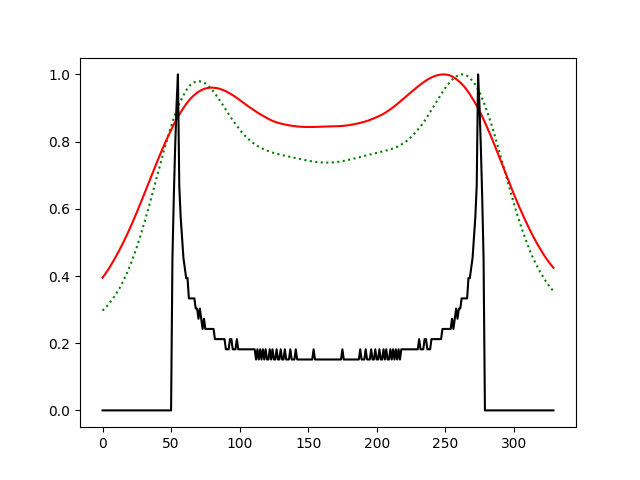

In [102]:
#plt.plot(convolved_projection_red.sum(axis=0)[midpoint_y]/convolved_projection_red.sum(axis=0)[midpoint_y].max(), c = "red", linestyle = ":")
plt.plot(convolved_projection_green.sum(axis=0)[midpoint_y]/convolved_projection_green.sum(axis=0)[midpoint_y].max(), c = "green", linestyle = ":")
plt.plot(convolved_projection_darkred.sum(axis=0)[midpoint_y]/convolved_projection_darkred.sum(axis=0)[midpoint_y].max(), c = "red")
plt.plot(a_cell.sum(axis=0)[midpoint_y]/a_cell.sum(axis=0)[midpoint_y].max(), c = "k")
#plt.xlim(50,125)
#plt.ylim(0.4,1)